In [5]:
# Script for generating a metasurface GDS layout

"""
This script generates the flat metasurface layout for electron beam lithography (ebeam) 
when the target phase profile follows a conformal phase distribution over a spherical lens 
with a curvature radius of 3.21 mm.

For full GDS generation, all cells should be merged. This script is structured 
for explanatory purposes, with separate sections for clarity.
"""

# Import necessary libraries
import gdspy
import pandas as pd
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from numpy import savetxt 
from scipy.integrate import quad
from datetime import date
import time

# Unit definitions
base_unit = 1  # Layout scale (microns)
m = base_unit * 1e6
nm = m * 1e-9
um = m * 1e-6
mm = m * 1e-3

# Input parameters
bias = 14.0  # Converted to nm in calculations
period = 310  # Period along x-axis (in nm)
periodX = 310 * nm  # Period along x-axis
periodY = 310 * nm  # Period along y-axis

# Metasurface dimensions
Xmax = 1 * mm  # Metasurface length
Ymax = 1 * mm  # Metasurface width

# Number of meta-atoms along each axis
Nx = round(Xmax / periodX) - 1
Ny = round(Ymax / periodY) - 1

# Phase quantization
phase_step = 2.8125 * (np.pi / 180)  # 360/128 in radians
n_phaseLevels = 128

# Generate timestamp
today = date.today()
timestamp = today.strftime("%Y%m%d")

# Print layout parameters for verification
print(f"Metasurface Layout Parameters ({timestamp}):")
print(f"  - Metasurface size: {Xmax} x {Ymax} (mm)")
print(f"  - Meta-atom period: {periodX:.2e} x {periodY:.2e} (m)")
print(f"  - Number of meta-atoms: {Nx} (x-axis) x {Ny} (y-axis)")
print(f"  - Phase quantization: {n_phaseLevels} levels, {phase_step:.4f} rad per step")

# TODO: Add GDS generation logic and additional calculations as needed.

Metasurface Layout Parameters (20250214):
  - Metasurface size: 1000.0 x 1000.0 (mm)
  - Meta-atom period: 3.10e-01 x 3.10e-01 (m)
  - Number of meta-atoms: 3225 (x-axis) x 3225 (y-axis)
  - Phase quantization: 128 levels, 0.0491 rad per step


We aim to **thermoform a metasurface onto a standard convex lens**, creating a **hybrid optical component** that combines the advantages of both technologies. Below is an image of the bulk lens. This means that the metasurface design must account for the incident angle. To achieve this, we create distinct meta-atom libraries for each set of incident angles, with increments of 5 degrees. For example, as indicated by the green arrow in the image below, we consider an angle of 
5 degrees×(i=5)−2.5 degree = 22.5 degrees to properly account for the incidence angle

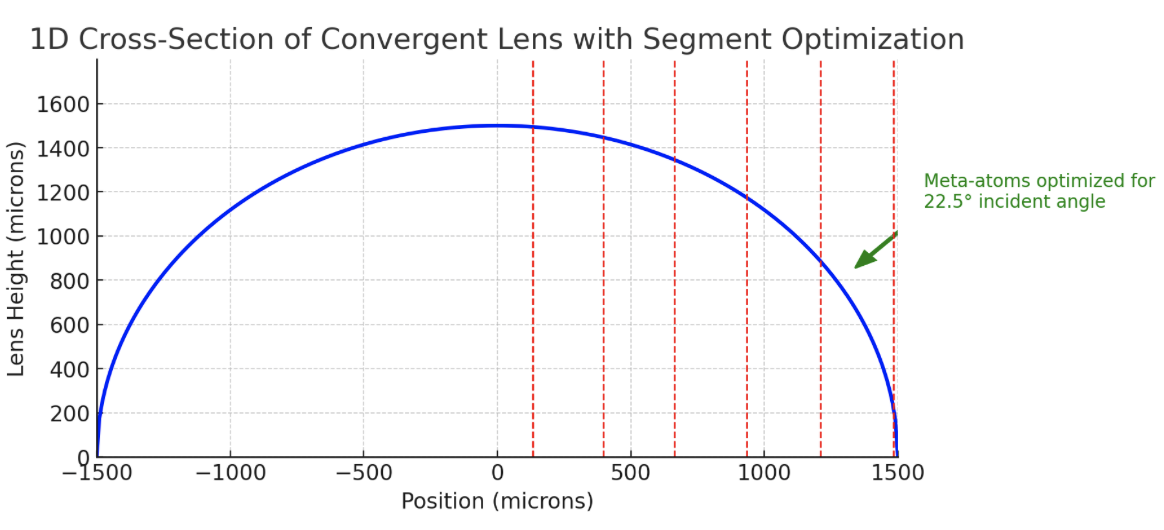

In [6]:
# ---------------------------------------------------------------
# Segmenting the Metasurface for Optimized Meta-Atom Angular Response
# ---------------------------------------------------------------

"""
We segment our metasurface into regions where the meta-atom angular response 
is optimized. Boundaries between angular segments (corrected by reverse deformation) 
for the old mold are as follows:
"""

# Angle boundaries (in microns) for different meta-atom responses along 
angle_boundaries = [
    132.7267091, 397.9370274, 664.1067295, 931.0170776, 
    1210.357483, 1482.263277, 1792.301508, 2072.877536, 
    2435.153535, 2728.784759
]

# Store the rounded limits in a list for practical use
limit_vec = [133, 398, 664, 934, 1210, 1482, 1792, 2072, 2435, 2728]

# ---------------------------------------------------------------
# Defining Output File Naming Convention
# ---------------------------------------------------------------

index=1 #segment number 
output_file_name = f'Filename_{5*index}deg_AngleCorr_{date}'

# ---------------------------------------------------------------
# Defining Phase and Angular Vectors
# ---------------------------------------------------------------

n_angles = len(limit_vec)  # Number of angular segments
angular_vector = np.linspace(0, 40, n_angles + 1)  # From 0 to 40 degrees
phase_vec = (np.pi / 180) * np.linspace(0, 360, n_phaseLevels + 1)

# ---------------------------------------------------------------
# Polynomial Coefficients for Phase-to-Diameter Mapping
# ---------------------------------------------------------------

"""
Each row in `polynomials` corresponds to a specific angular segment.
The columns are polynomial coefficients fitting the correspondence 
from phase to diameter (period = 310nm, height = 1µm, wavelength = 940nm).
Meta-atom index: 3.484, Surrounding index: 1.53.
"""

polynomials = np.array([
    [1.60E-05, 0.000155439, -0.003231656, 0.029846808, 0.121221357],
    [1.64E-05, 0.000148518, -0.003196733, 0.029765902, 0.121241693],
    [1.74E-05, 0.000130644, -0.003103352, 0.029538916, 0.1212999],
    [1.86E-05, 0.000106923, -0.00297322, 0.029199022, 0.121390238],
    [1.84E-05, 9.73E-05, -0.002884626, 0.028853112, 0.121489038],
    [1.65E-05, 0.000106891, -0.002864284, 0.02855391, 0.12158221],
    [1.30E-05, 0.000138539, -0.002936535, 0.028360904, 0.121647237],
    [5.74E-06, 0.000219328, -0.003218521, 0.028452606, 0.121623903],
    [-7.23E-06, 0.000373611, -0.003796595, 0.028941888, 0.121465347]
])

# ---------------------------------------------------------------
# Phase-to-Diameter Conversion Function
# ---------------------------------------------------------------

def phase_to_diameter(coefficients, phase_values):
    """
    Converts phase values to corresponding diameters using polynomial fitting.
    
    Parameters:
    - coefficients: 2D array where each row contains polynomial coefficients.
    - phase_values: 1D array of phase values.

    Returns:
    - diameters: 2D array of calculated diameters.
    """
    num_angles = coefficients.shape[0]
    num_phases = phase_values.shape[0]
    
    diameters = np.zeros((num_angles, num_phases))
    
    for i in range(num_angles):
        # Compute polynomial values for each phase
        diameters[i] = (
            coefficients[i, 4] +
            coefficients[i, 3] * phase_values +
            coefficients[i, 2] * phase_values ** 2 +
            coefficients[i, 1] * phase_values ** 3 +
            coefficients[i, 0] * phase_values ** 4
        )
    
    return diameters

# Compute diameter matrix from phase values
diam = phase_to_diameter(polynomials, phase_vec)

# ---------------------------------------------------------------
# Scaling and Bias Correction, accounts for electron beam writing effects
# ---------------------------------------------------------------

factor = um * np.ones((9, n_phaseLevels + 1))  # Scale factor in microns
diameter = np.multiply(factor, diam) - bias * nm  # Adjusted diameter matrix

# ---------------------------------------------------------------
# Debugging Output
# ---------------------------------------------------------------

print("\nGenerated Metasurface Data:")
print(f"  - Angular Segments: {n_angles}")
print(f"  - Output Filename: {output_file_name}")
print(f"  - Diameter Matrix Shape: {diameter.shape}")



Generated Metasurface Data:
  - Angular Segments: 10
  - Output Filename: Filename_5deg_AngleCorr_<class 'datetime.date'>
  - Diameter Matrix Shape: (9, 129)


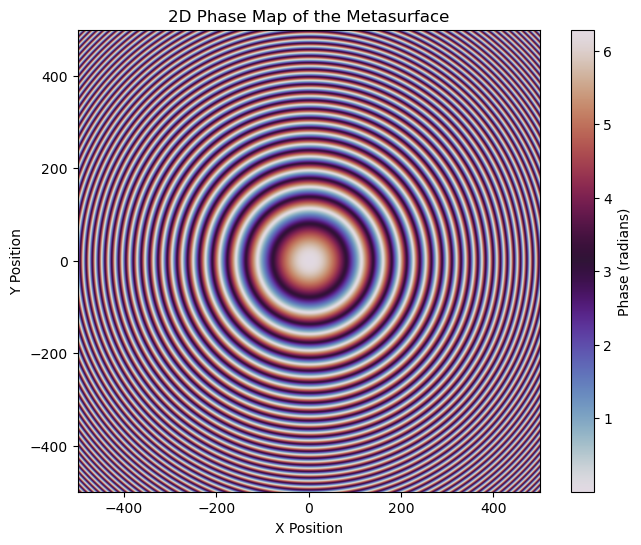

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Generating phase map correction for BFL + 4mm
x = np.linspace(-Xmax / 2, Nx * periodX - Xmax / 2, Nx)
y = np.linspace(-Ymax / 2, Ny * periodY - Ymax / 2, Ny)

# Create meshgrid for spatial coordinates
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

# Define target phase map coefficients from Zemax simulations
coeffs_phaseMap = np.array([
    -4.973830169837029E+006, -6.499539028024775E+008, -2.501688494173564E+011,
    -1.067364139495181E+014, -4.836776365296349E+017, 3.317785766312701E+021,
    -1.731032252580379E+025, 5.139459724125223E+028, -7.030919285809993E+031,
    -3.078069633090000E+034, 2.168674932858883E+038, -1.923135071970658E+041
])

# Normalize radial distance
r_max = 100 * mm
R_norm = np.clip(R / r_max, 0, 1)  # Normalize values to maximum radius

# Compute phase map using polynomial expansion
powers = np.arange(2, 26, 2)  # Exponents from 2 to 24
#phase_map0 = np.sum(coeffs_phaseMap[:] * (R_norm**powers), axis=0)
phase_map0 = np.sum(coeffs_phaseMap[:, None, None] * (R_norm[None, :, :] ** powers[:, None, None]), axis=0)


# Convert phase map to modulo 2π
phase_map = np.remainder(phase_map0, 2 * np.pi)  # In radians

# Plot 2D Phase Map
plt.figure(figsize=(8, 6))
plt.imshow(phase_map, extent=[x.min(), x.max(), y.min(), y.max()], cmap='twilight', origin='lower')
plt.colorbar(label="Phase (radians)")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("2D Phase Map of the Metasurface")
plt.grid(False)
plt.show()


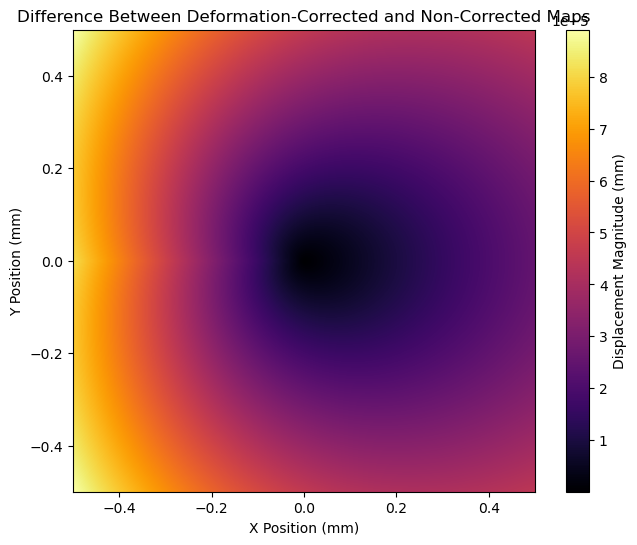

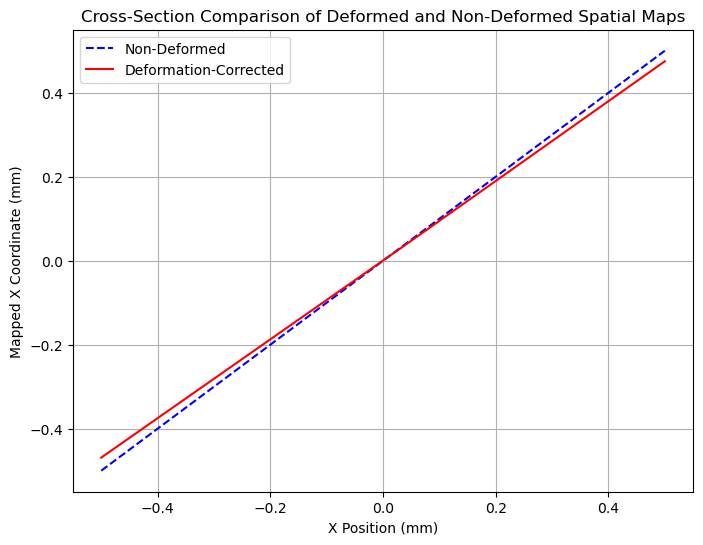

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Radial deformation function
def radial_deformation(R):
    """Computes radial deformation factor."""
    return 1 + 0.01 * ((-0.000002) * (R**2) + (0.0016) * R + 5.2951)

# Inverse radial deformation function
def inverse_radial_deformation(R):
    """Computes the inverse radial deformation factor."""
    return (1 + 0.01 * ((-0.000002) * (R**2) + (0.0016) * R + 5.2951)) ** (-1)

# Integration to extract new radial positions
def inverse_radial_displacement(r):
    """Integrates inverse radial deformation to compute displacement."""
    return quad(inverse_radial_deformation, 0, r)[0]

# Vectorized inverse radial displacement computation
def inverse_radial_displacement_map(X):
    """Computes the inverse radial displacement map efficiently using vectorized operations."""
    R = np.sqrt(X[..., 0]**2 + X[..., 1]**2)
    inv_radial_disp = np.vectorize(inverse_radial_displacement)(R)
    return np.stack((inv_radial_disp * X[..., 0] / R, inv_radial_disp * X[..., 1] / R), axis=-1)

# Convert Cartesian coordinates to cylindrical (r, theta)
def cylindrical_map(X):
    """Converts Cartesian (x, y) to cylindrical (r, θ)."""
    R = np.sqrt((X[..., 0])**2 + X[..., 1]**2)
    Theta = np.arctan2(X[..., 1], X[..., 0])
    return np.stack((R, Theta), axis=-1)

# Convert cylindrical (r, theta) back to Cartesian (x, y)
def cartesian_map(X_cyl):
    """Converts cylindrical (r, θ) back to Cartesian (x, y)."""
    X = X_cyl[..., 0] * np.cos(X_cyl[..., 1])
    Y = X_cyl[..., 0] * np.sin(X_cyl[..., 1])
    return np.stack((X, Y), axis=-1)

# Generate spatial map of (x, y) coordinates over the phase map grid
def spatial_map_generator(periodX, periodY, phaseMap, Xmax, Ymax):
    """Generates a spatial map representing (x, y) grid points over the phase map area."""
    Ny, Nx = phaseMap.shape
    x = np.linspace(-Xmax * 0.5, Xmax * 0.5, Nx)
    y = np.linspace(-Ymax * 0.5, Ymax * 0.5, Ny)
    X, Y = np.meshgrid(x, y)
    return np.stack((X, Y), axis=-1)

# Example parameters
Xmax, Ymax = 1e-3, 1e-3  # Field size (1 mm)
periodX, periodY = Xmax / 512, Ymax / 512  # Pixel size
phaseMap = np.ones((512, 512))  # Example placeholder phase map

# Generate spatial maps
spatial_map0 = spatial_map_generator(periodX, periodY, phaseMap, Xmax, Ymax)
cylindrical_coords = cylindrical_map(spatial_map0)
radial_displacement = inverse_radial_displacement_map(cylindrical_coords)
cartesian_after_deformation = cartesian_map(radial_displacement)

# Compute difference between deformation-corrected and original spatial maps
displacement_magnitude = np.linalg.norm(cartesian_after_deformation - spatial_map0, axis=-1)

# Plot the difference as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(displacement_magnitude, extent=[-(Xmax/2)*1e3, (Xmax/2)*1e3, (-Ymax/2)*1e3, (Ymax/2)*1e3], cmap="inferno", origin="lower")
plt.colorbar(label="Displacement Magnitude (mm)")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.title("Difference Between Deformation-Corrected and Non-Corrected Maps")
plt.show()

# Extract a cross-section along the center row (Y = 0)
Ny, Nx = phaseMap.shape
center_row = Ny // 2  # Middle row index

# Extract X positions and Y values from spatial maps
x_positions = np.linspace(-Xmax * 0.5, Xmax * 0.5, Nx) * 1e3  # Convert to mm
original_cross_section = spatial_map0[center_row, :, 0] * 1e3  # Convert to mm
deformed_cross_section = cartesian_after_deformation[center_row, :, 0] * 1e3  # Convert to mm

# Plot the cross-section comparison
plt.figure(figsize=(8, 6))
plt.plot(x_positions, original_cross_section, label="Non-Deformed", linestyle="--", color="blue")
plt.plot(x_positions, deformed_cross_section, label="Deformation-Corrected", linestyle="-", color="red")
plt.xlabel("X Position (mm)")
plt.ylabel("Mapped X Coordinate (mm)")
plt.title("Cross-Section Comparison of Deformed and Non-Deformed Spatial Maps")
plt.legend()
plt.grid(True)
plt.show()


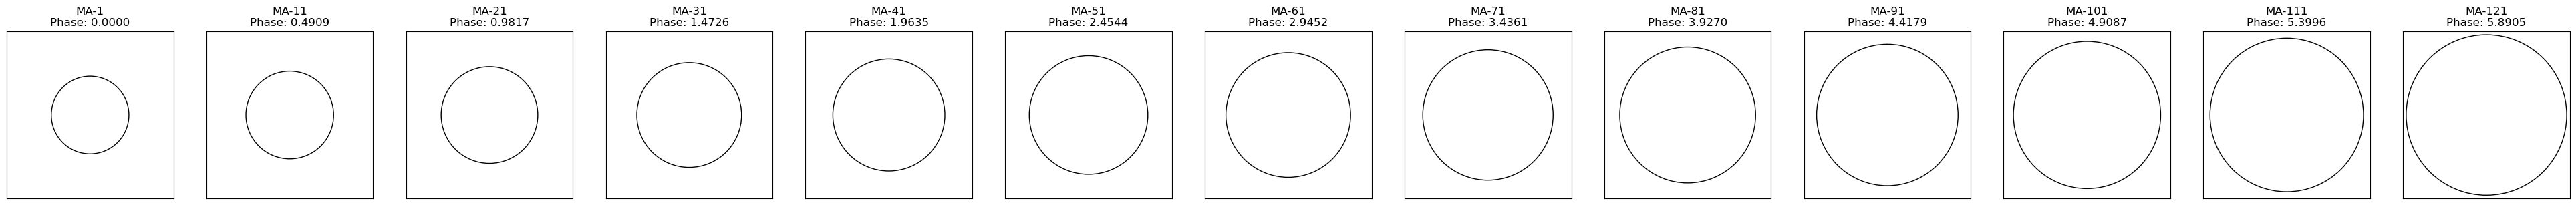

In [17]:
# Function to clear polygons from a GDS cell
def clear_cell(cell):
    cell.remove_polygons(lambda pts, layer, datatype: True)

# Define layer and datatype tags
ld_Si = {"layer": 1, "datatype": 1}

# Creating a new GDSII library
gdspy.current_library = gdspy.GdsLibrary()
lib = gdspy.GdsLibrary()

# Mapping phase values to meta-atom radii
metaatom_radius = 0.5 * diameter[index]

phase_to_radius = [(phase_vec[i], round(metaatom_radius[i], 4)) for i in range(n_phaseLevels)]
phase_values = [entry[0] for entry in phase_to_radius]

# Generating meta-atom library
disks = [gdspy.Round((0, 0), radius, tolerance=0.001) for radius in metaatom_radius]

# Creating cells for each meta-atom
MA_cells = [lib.new_cell(f'metaatom-{i+1}').add(disks[i]) for i in range(len(metaatom_radius))]

# Function to map phase values to corresponding meta-atom cells
def phase_to_cell_map(center, phase, phase_values, MA_cells):
    for i, phase_value in enumerate(phase_values):
        if phase_value - phaseStep / 2 <= phase < phase_value + phaseStep / 2:
            return gdspy.CellReference(MA_cells[i], center)
    return gdspy.CellReference(MA_cells[0], center) if phase > max(phase_values) + phaseStep / 2 else None

# Function to generate a metasurface layout
def metalens_generator(phase_map, phase_to_cell_map, spatial_map):
    metasurface = []
    for x in range(len(spatial_map)):
        for y in range(len(spatial_map[0])):
            if spatial_map[x][y][0] != 'x' and spatial_map[x][y][1] != 'x':
                radius = np.linalg.norm(spatial_map[x][y])
                if (0 < index < len(limit_vec) - 1 and limit_vec[index-1] < radius < limit_vec[index]) \
                or (index == 0 and radius < limit_vec[index]) \
                or (index == len(limit_vec) - 1 and radius > limit_vec[index]):
                    metasurface.append(phase_to_cell_map(spatial_map[x][y], phase_map[x][y], phase_values, MA_cells))
    return metasurface
 
# Plot one in every ten disks in a single row
sample_indices = range(0, len(metaatom_radius), 10)
fig, axes = plt.subplots(1, len(sample_indices), figsize=(len(sample_indices) * 3, 3))
if len(sample_indices) == 1:
    axes = [axes]

for ax, i in zip(axes, sample_indices):
    radius = metaatom_radius[i]
    phase = phase_values[i]  # Corresponding phase value
    circle = plt.Circle((0, 0), radius, fill=False, edgecolor='black', linewidth=1)
    ax.add_patch(circle)
    ax.set_xlim(-max(metaatom_radius) - 1e-6, max(metaatom_radius) + 1e-6)
    ax.set_ylim(-max(metaatom_radius) - 1e-6, max(metaatom_radius) + 1e-6)
    ax.set_title(f'MA-{i+1}\nPhase: {phase:.4f}')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In [18]:
metalens = metalens_generator(phaseMap, phase_to_cell_map, cartesian_after_deformation)

Lens=gdspy.Cell("Lens-1")
Lens.add(metalens)

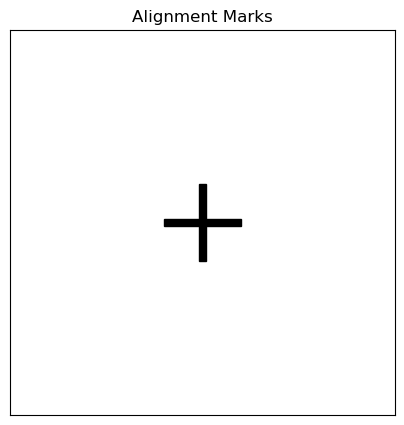

--- 0.022171974182128906 seconds ---


In [25]:
# Adding alignment marks
am_pos = [(-2 * mm, -2 * mm)]
cross_length = 200 * um
cross_width = 20 * um

crosses = [gdspy.boolean(
    gdspy.Rectangle((pos[0] + cross_length/2, pos[1] + cross_width/2), (pos[0] - cross_length/2, pos[1] - cross_width/2)),
    gdspy.Rectangle((pos[0] + cross_width/2, pos[1] + cross_length/2), (pos[0] - cross_width/2, pos[1] - cross_length/2)),
    "or") for pos in am_pos]

align_marks = gdspy.Cell('alignment-marks')
align_marks.add(crosses)

# Create figure
fig, ax = plt.subplots(figsize=(5, 5))

# Plot alignment crosses
for pos in am_pos:
    x, y = pos
    
    # Horizontal and vertical bars of the cross
    h_rect = plt.Rectangle((x - cross_length / 2, y - cross_width / 2), cross_length, cross_width, color='black')
    v_rect = plt.Rectangle((x - cross_width / 2, y - cross_length / 2), cross_width, cross_length, color='black')
    
    ax.add_patch(h_rect)
    ax.add_patch(v_rect)

# Set plot limits
ax.set_xlim(-2.5 * mm, -1.5 * mm)
ax.set_ylim(-2.5 * mm, -1.5 * mm)
ax.set_aspect('equal')
ax.set_title("Alignment Marks")
ax.set_xticks([])
ax.set_yticks([])

# Show plot
plt.show()


In [ ]:
#writing gds file
start_time = time.time()
gdspy.current_library = gdspy.GdsLibrary()
gdspy.current_library.add(Lens)
Lens.add(align_marks)
gdspy.write_gds(output_file_name + '.gds')
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.06894493103027344 seconds ---
